In [ ]:
import cv2
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import PIL.Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.14.0


In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 13.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
BATCH_SIZE = 16
EPOCHS = 30
IM_SIZE_W = 300
IM_SIZE_H = 400

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.random.set_seed(10)

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
  print("GPU device not found")
print('Found GPU as: {}'.format(device_name))

Found GPU as: /device:GPU:0


In [ ]:
from google.colab import drive
drive. mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/archive (3)'):
    print(dirname)

/content/drive/MyDrive/archive (3)
/content/drive/MyDrive/archive (3)/Curated X-Ray Dataset
/content/drive/MyDrive/archive (3)/Curated X-Ray Dataset/COVID-19
/content/drive/MyDrive/archive (3)/Curated X-Ray Dataset/Pneumonia-Viral
/content/drive/MyDrive/archive (3)/Curated X-Ray Dataset/Normal
/content/drive/MyDrive/archive (3)/Curated X-Ray Dataset/Pneumonia-Bacterial


In [ ]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/archive (3)/Curated X-Ray Dataset/*/*')
print(len(filenames))
filenames[:3]

9218


['/content/drive/MyDrive/archive (3)/Curated X-Ray Dataset/COVID-19/COVID-19 (1252).jpg',
 '/content/drive/MyDrive/archive (3)/Curated X-Ray Dataset/COVID-19/COVID-19 (1251).jpg',
 '/content/drive/MyDrive/archive (3)/Curated X-Ray Dataset/COVID-19/COVID-19 (1249).jpg']

In [ ]:
data = pd.DataFrame()
for el in range(0, len(filenames)):
    target = filenames[el].split('/')[-2]
    path = filenames[el]

    data.loc[el, 'filename'] = path
    data.loc[el, 'class'] = target

print(data['class'].value_counts(dropna=False))
data

Normal                 3270
Pneumonia-Bacterial    3011
Pneumonia-Viral        1656
COVID-19               1281
Name: class, dtype: int64


,filename,class
0,/content/drive/MyDrive/archive (3)/Curated X-R...,COVID-19
1,/content/drive/MyDrive/archive (3)/Curated X-R...,COVID-19
2,/content/drive/MyDrive/archive (3)/Curated X-R...,COVID-19
3,/content/drive/MyDrive/archive (3)/Curated X-R...,COVID-19
4,/content/drive/MyDrive/archive (3)/Curated X-R...,COVID-19
...,...,...
9213,/content/drive/MyDrive/archive (3)/Curated X-R...,Normal
9214,/content/drive/MyDrive/archive (3)/Curated X-R...,Normal
9215,/content/drive/MyDrive/archive (3)/Curated X-R...,Normal
9216,/content/drive/MyDrive/archive (3)/Curated X-R...,Normal


In [ ]:
data = shuffle(data, random_state=42)
data.reset_index(drop=True, inplace=True)
data

,filename,class
0,/content/drive/MyDrive/archive (3)/Curated X-R...,Pneumonia-Viral
1,/content/drive/MyDrive/archive (3)/Curated X-R...,Pneumonia-Bacterial
2,/content/drive/MyDrive/archive (3)/Curated X-R...,Normal
3,/content/drive/MyDrive/archive (3)/Curated X-R...,Pneumonia-Bacterial
4,/content/drive/MyDrive/archive (3)/Curated X-R...,Pneumonia-Bacterial
...,...,...
9213,/content/drive/MyDrive/archive (3)/Curated X-R...,Pneumonia-Viral
9214,/content/drive/MyDrive/archive (3)/Curated X-R...,Pneumonia-Viral
9215,/content/drive/MyDrive/archive (3)/Curated X-R...,Pneumonia-Viral
9216,/content/drive/MyDrive/archive (3)/Curated X-R...,COVID-19


**Model for Normal**

In [ ]:
change = {
    'Normal': '0',
    'Pneumonia-Bacterial': '1',
    'Pneumonia-Viral': '0',
    'COVID-19': '0',
}

data['class'] = data['class'].map(change)
data

,filename,class
0,/content/drive/MyDrive/archive (3)/Curated X-R...,0
1,/content/drive/MyDrive/archive (3)/Curated X-R...,1
2,/content/drive/MyDrive/archive (3)/Curated X-R...,0
3,/content/drive/MyDrive/archive (3)/Curated X-R...,1
4,/content/drive/MyDrive/archive (3)/Curated X-R...,1
...,...,...
9213,/content/drive/MyDrive/archive (3)/Curated X-R...,0
9214,/content/drive/MyDrive/archive (3)/Curated X-R...,0
9215,/content/drive/MyDrive/archive (3)/Curated X-R...,0
9216,/content/drive/MyDrive/archive (3)/Curated X-R...,0


In [ ]:
indexes = []

def func(x):
  if x[-4:] != '.jpg':
    idx = data[data['filename'] == x].index
    indexes.append(idx[0])
    print(idx[0], x)
  return x

data['filename'].map(func)

print(data.shape)
data.drop(index=indexes, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

(9218, 2)
(9218, 2)


Image shape

In [ ]:
for el in range(100, 120):
  path = data.loc[el, 'filename']
  img = cv2.imread(path)
  print(img.shape)

(300, 400, 3)
(1024, 1024, 3)
(300, 400, 3)
(1024, 1024, 3)
(3308, 3670, 3)
(792, 1272, 3)
(172, 428, 3)
(300, 400, 3)
(1864, 2096, 3)
(708, 684, 3)
(784, 1360, 3)
(1072, 1624, 3)
(612, 536, 3)
(2175, 1974, 3)
(628, 682, 3)
(300, 400, 3)
(529, 653, 3)
(1024, 1024, 3)
(300, 400, 3)
(1024, 1024, 3)


Split data into train and validation

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42, stratify=data['class'])
print(train_data['class'].value_counts(dropna=False))
print(val_data['class'].value_counts(dropna=False))

0    5586
1    2710
Name: class, dtype: int64
0    621
1    301
Name: class, dtype: int64


Split train_data, test_data

In [ ]:
train_data, test_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data['class'])
print(train_data['class'].value_counts(dropna=False))
print(test_data['class'].value_counts(dropna=False))

0    5027
1    2439
Name: class, dtype: int64
0    559
1    271
Name: class, dtype: int64


Define ImageDataGenerator and Augmentation (for train)

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    brightness_range=[0.95, 1.0],
    height_shift_range=0.01,
    width_shift_range=0.01,
    #rotation_range=10,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_data,
    x_col="filename",
    y_col="class",
    target_size=(IM_SIZE_W, IM_SIZE_H),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    num_parallel_calls=AUTOTUNE
)

val_gen = test_datagen.flow_from_dataframe(
    val_data,
    x_col="filename",
    y_col="class",
    target_size=(IM_SIZE_W, IM_SIZE_H),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    num_parallel_calls=AUTOTUNE
)

test_gen = test_datagen.flow_from_dataframe(
    test_data,
    x_col="filename",
    y_col="class",
    target_size=(IM_SIZE_W, IM_SIZE_H),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    num_parralel_calls=AUTOTUNE
)

Found 7466 validated image filenames belonging to 2 classes.
Found 922 validated image filenames belonging to 2 classes.
Found 830 validated image filenames belonging to 2 classes.


[0. 1.]


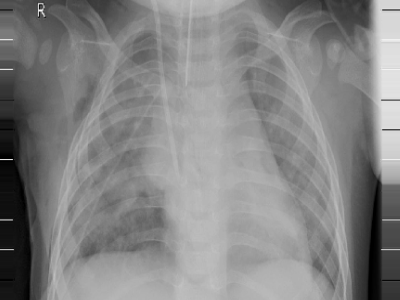

In [ ]:
from IPython.display import display

# Отримання одного зображення та його мітки з генератора
image, label = train_gen.next()
image = image[0]  # Обираємо перше зображення
print(label[0])

# Перетворення типу даних до 'uint8'
image_uint8 = (image * 255).astype('uint8')

# Створення об'єкту Image з NumPy масиву
image_pil = PIL.Image.fromarray(image_uint8.squeeze())  # Видаляємо останнє вимірювання (1, 1, 1)

# Відображення зображення
display(image_pil)

Define CNN model

In [ ]:
def create_model():
  with tf.device('/gpu:0'):

    # Model input
    input_layer = layers.Input(shape=(IM_SIZE_W, IM_SIZE_H, 1), name='input')

    # First block
    x = layers.Conv2D(filters=256, kernel_size=2,
                      activation='relu', padding='same',
                      name='conv2d_1')(input_layer)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
    x = layers.Dropout(0.1, name='dropout_1')(x)

    # Second block
    x = layers.Conv2D(filters=256, kernel_size=2,
                      activation='relu', padding='same',
                      name='conv2d_2')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
    x = layers.Dropout(0.1, name='dropout_2')(x)

    # Third block
    x = layers.Conv2D(filters=256, kernel_size=2,
                      activation='relu', padding='same',
                      name='conv2d_3')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
    x = layers.Dropout(0.1, name='dropout_3')(x)

    # Fourth block
    x = layers.Conv2D(filters=512, kernel_size=2,
                      activation='relu', padding='same',
                      name='conv2d_4')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
    x = layers.Dropout(0.1, name='dropout_4')(x)

    # Fifth block
    x = layers.Conv2D(filters=512, kernel_size=2,
                      activation='relu', padding='same',
                      name='conv2d_5')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
    x = layers.Dropout(0.1, name='dropout_5')(x)

    # Sixth block
    x = layers.Conv2D(filters=1024, kernel_size=2,
                      activation='relu', padding='same',
                      name='conv2d_6')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
    x = layers.Dropout(0.1, name='dropout_6')(x)

    # Seventh block
    x = layers.Conv2D(filters=1024, kernel_size=2,
                      activation='relu', padding='same',
                      name='conv2d_7')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
    x = layers.Dropout(0.1, name='dropout_7')(x)



    # GlobalAveragePooling
    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
    x = layers.Flatten()(x)

    # Head
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dropout(0.1, name='dropout_head_2')(x)
    x = layers.Dense(256, activation='relu')(x)

    # Output
    output = layers.Dense(units=2,
                          activation='softmax',
                          name='output')(x)

    model = Model(input_layer, output)


    F_1_macro = tfa.metrics.f_scores.F1Score(num_classes=2, average="macro", name='f1_macro')

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=F_1_macro)

  return model


model = create_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300, 400, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 400, 256)     1280      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 150, 200, 256)     0         
                                                                 
 dropout_1 (Dropout)         (None, 150, 200, 256)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 200, 256)     262400    
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 75, 100, 256)      0         
                                                                 
 dropout_2 (Dropout)         (None, 75, 100, 256)      0     

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/pneumonia_bacterial.keras')

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

init_time = datetime.datetime.now()

train_steps = train_gen.samples // BATCH_SIZE
valid_steps = val_gen.samples // BATCH_SIZE

early_stopping = EarlyStopping(monitor="val_loss", patience=8, mode="min")

checkpoint = ModelCheckpoint("loss-{val_loss:.4f}.h5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True, mode="min")
#checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True, mode="min")

learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4, min_lr=1e-9, verbose=1, mode="min")

history = model.fit( train_gen, validation_data=val_gen, batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=train_steps, validation_steps=valid_steps, callbacks=[ checkpoint, early_stopping, learning_rate_reduction], verbose=1, )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time: {str(requared_time)}\n')mk

model.save('pneumonia_covid19.keras')

Epoch 1/30
466/466 [==============================] - 4171s 9s/step - loss: 0.6321 - accuracy: 0.6740 - val_loss: 0.6322 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 2/30
466/466 [==============================] - 429s 919ms/step - loss: 0.6322 - accuracy: 0.6729 - val_loss: 0.6349 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 3/30
466/466 [==============================] - 430s 921ms/step - loss: 0.6325 - accuracy: 0.6734 - val_loss: 0.6319 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 4/30
466/466 [==============================] - 434s 930ms/step - loss: 0.6327 - accuracy: 0.6734 - val_loss: 0.6319 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 5/30
466/466 [==============================] - 432s 927ms/step - loss: 0.6320 - accuracy: 0.6736 - val_loss: 0.6327 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 6/30
466/466 [==============================] - 429s 920ms/step - loss: 0.6323 - accuracy: 0.6733 - val_loss: 0.6321 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 7/30
466/466 [============================

In [ ]:
loss, acc = model.evaluate( test_gen, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

#print(model.predict(test_images).shape)

52/52 - 130s - loss: 0.1423 - f1_macro: 0.9584 - 130s/epoch - 3s/step
Restored model, accuracy: 95.84%


In [ ]:
model.save('normal.keras')

In [ ]:
new_model = tf.keras.models.load_model('normal.keras')

# Show the model architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300, 400, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 400, 256)     1280      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 150, 200, 256)     0         
                                                                 
 dropout_1 (Dropout)         (None, 150, 200, 256)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 200, 256)     262400    
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 75, 100, 256)      0         
                                                                 
 dropout_2 (Dropout)         (None, 75, 100, 256)      0     

In [ ]:
loss, acc = new_model.evaluate( test_gen, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

#print(model.predict(test_images).shape)

52/52 - 15s - loss: 0.1423 - f1_macro: 0.9584 - 15s/epoch - 282ms/step
Restored model, accuracy: 95.84%


[0. 1.]


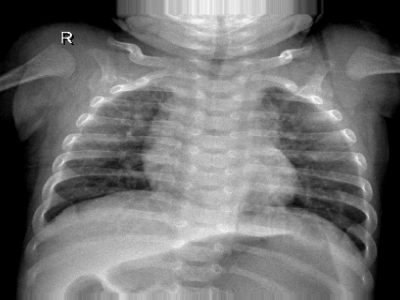

In [ ]:
# Отримання одного зображення та його мітки з генератора
image, label = train_gen.next()
image = image[0]  # Обираємо перше зображення
print(label[0])

# Перетворення типу даних до 'uint8'
image_uint8 = (image * 255).astype('uint8')

# Створення об'єкту Image з NumPy масиву
image_pil = PIL.Image.fromarray(image_uint8.squeeze())  # Видаляємо останнє вимірювання (1, 1, 1)

# Відображення зображення
display(image_pil)

In [ ]:
res = new_model.predict(test_gen, verbose=2)

52/52 - 13s - 13s/epoch - 250ms/step


In [ ]:
res[0]

array([1.7932490e-04, 9.9982065e-01], dtype=float32)

In [ ]:
test_gen[0][1][0]

array([0., 1.], dtype=float32)

In [ ]:
res[3]

array([0.97437716, 0.02562287], dtype=float32)

In [ ]:
test_gen[0][1][3]

array([1., 0.], dtype=float32)